# PyTorch CNN Tutorial for Skin Cancer Classification

In this tutorial, we'll build a Convolutional Neural Network (CNN) using PyTorch to classify skin lesions from the HAM10000 dataset. This dataset contains 10,000 dermatoscopic images of common pigmented skin lesions across seven diagnostic categories.

## Table of Contents
1. [Setup and Dependencies](#setup-and-dependencies)
2. [Dataset Overview](#dataset-overview)
3. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
4. [Building the CNN Model](#building-the-cnn-model)
5. [Training the Model](#training-the-model)
6. [Evaluating Model Performance](#evaluating-model-performance)
7. [Visualizing Results](#visualizing-results)
8. [Making Predictions](#making-predictions)
9. [Bonus: Applying Transfer Learning](#bonus-applying-transfer-learning)

## Setup and Dependencies


## Prelim: Data download from Kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:15<00:00, 50.4MB/s]
100% 5.20G/5.20G [01:15<00:00, 73.6MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip


Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

In [5]:
# Install necessary packages (run this if needed)
# !pip install torch torchvision pandas matplotlib seaborn scikit-learn pillow tqdm

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Dataset Overview

The HAM10000 dataset consists of 10,015 dermatoscopic images across 7 different categories:
- Melanocytic nevi (nv)
- Melanoma (mel)
- Benign keratosis-like lesions (bkl)
- Basal cell carcinoma (bcc)
- Actinic keratoses (akiec)
- Vascular lesions (vasc)
- Dermatofibroma (df)

Let's first explore the metadata:

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


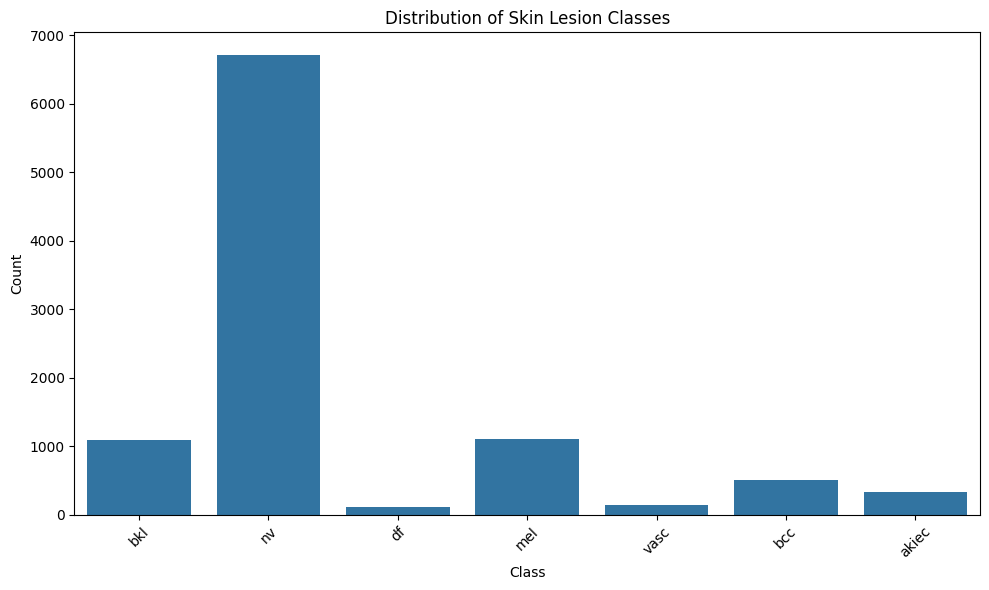

In [7]:

# Load the metadata
metadata = pd.read_csv('HAM10000_metadata.csv')

# Display first few rows
print(metadata.head())

# Check class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='dx', data=metadata)
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:

class_counts = metadata['dx'].value_counts()
print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images ({count/len(metadata)*100:.2f}%)")


Class distribution:
nv: 6705 images (66.95%)
mel: 1113 images (11.11%)
bkl: 1099 images (10.97%)
bcc: 514 images (5.13%)
akiec: 327 images (3.27%)
vasc: 142 images (1.42%)
df: 115 images (1.15%)


## Data Loading and Preprocessing

Now, let's create a custom PyTorch dataset for loading the HAM10000 images:

In [9]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        """
        Args:
            df (pandas.DataFrame): Dataframe with image metadata
            image_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

        # Create a mapping from diagnosis to integer label
        self.classes = sorted(df['dx'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image ID and path
        img_id = self.df.iloc[idx]['image_id']
        # Check both folders since images are split between them
        img_path = os.path.join(self.image_dir, 'HAM10000_images_part_1', f"{img_id}.jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.image_dir, 'HAM10000_images_part_2', f"{img_id}.jpg")

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get label
        diagnosis = self.df.iloc[idx]['dx']
        label = self.class_to_idx[diagnosis]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:

# Define data transformations
# Data augmentation is done only for training dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizing pixels based on ImageNet's average RGB values
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [11]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['dx'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets
train_dataset = SkinLesionDataset(
    df=train_df,
    image_dir='.',  # Adjust this path as needed
    transform=data_transforms['train']
)

val_dataset = SkinLesionDataset(
    df=val_df,
    image_dir='.',  # Adjust this path as needed
    transform=data_transforms['val']
)


Training set size: 8012
Validation set size: 2003


In [12]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get class names for reference
class_names = train_dataset.classes
print(f"Class names: {class_names}")

Class names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



## Building the CNN Model

Now let's build our CNN architecture:


In [13]:
class SkinLesionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinLesionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        # After 4 max-pooling operations with 224x224 input: 224/(2^4) = 14
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third convolutional block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Fourth convolutional block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten the output
        x = x.view(-1, 256 * 14 * 14)

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [14]:
# Initialize the model
model = SkinLesionCNN(num_classes=len(class_names))
model = model.to(device)

# Print model summary
print(model)

SkinLesionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """
    Train the model and evaluate on validation set after each epoch
    """
    # Track best model
    best_acc = 0.0
    best_model_wts = model.state_dict()

    # Track loss and accuracy
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # No gradient during validation
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        print()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

# Save the trained model
torch.save(model.state_dict(), 'skin_lesion_cnn.pth')

Epoch 1/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 2.1245 Acc: 0.6323


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.9143 Acc: 0.6850

Epoch 2/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 1.0578 Acc: 0.6697


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.9547 Acc: 0.6945

Epoch 3/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 1.0021 Acc: 0.6750


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8802 Acc: 0.6865

Epoch 4/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.9845 Acc: 0.6769


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8652 Acc: 0.6960

Epoch 5/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.9586 Acc: 0.6811


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8389 Acc: 0.7014

Epoch 6/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.9386 Acc: 0.6799


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8033 Acc: 0.7059

Epoch 7/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.9153 Acc: 0.6837


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8357 Acc: 0.6940

Epoch 8/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.9130 Acc: 0.6905


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8311 Acc: 0.6925

Epoch 9/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8936 Acc: 0.6902


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.7991 Acc: 0.7094

Epoch 10/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8759 Acc: 0.6922


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8177 Acc: 0.6900

Epoch 11/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8788 Acc: 0.6966


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8384 Acc: 0.7094

Epoch 12/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8738 Acc: 0.6947


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.7758 Acc: 0.7114

Epoch 13/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8529 Acc: 0.6926


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.7951 Acc: 0.7119

Epoch 14/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8456 Acc: 0.7019


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.7632 Acc: 0.7214

Epoch 15/15
----------


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.8435 Acc: 0.6986


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.8092 Acc: 0.7049



In [17]:
def evaluate_model(model, dataloader):
    """
    Evaluate model performance on the given dataloader
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [18]:
y_true, y_pred = evaluate_model(model, val_loader)


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

In [19]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       akiec       0.24      0.25      0.24        65
         bcc       0.60      0.03      0.06       103
         bkl       0.44      0.20      0.27       220
          df       0.00      0.00      0.00        23
         mel       0.49      0.21      0.29       223
          nv       0.75      0.97      0.85      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.70      2003
   macro avg       0.36      0.24      0.24      2003
weighted avg       0.64      0.70      0.64      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


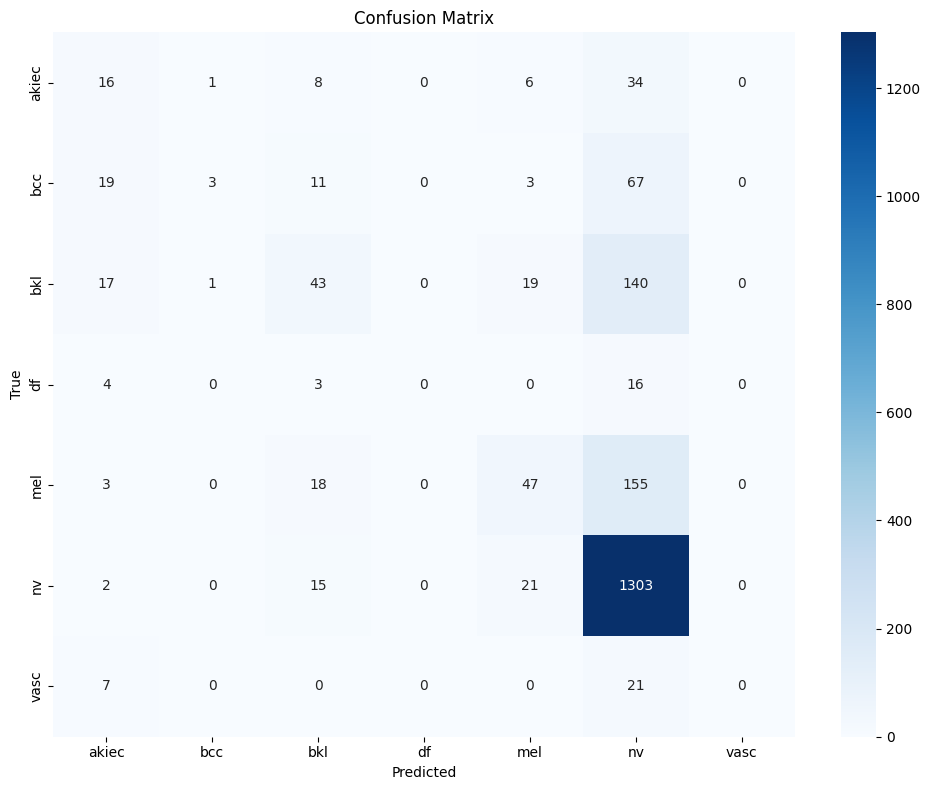

In [20]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Visualizing Results

Let's visualize the training process and some predictions:

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, dataloader, class_names, num_images=12):
    """
    Visualize some predictions from the model
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(3, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}',
                            color=('green' if preds[j] == labels[j] else 'red'))

                # Denormalize image
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return
        plt.tight_layout()
        plt.show()



In [ ]:
# Visualize predictions
visualize_predictions(model, val_loader, class_names)

## Making Predictions

Let's create a function to make predictions on new images:

In [ ]:
def predict_image(model, image_path, transform, class_names):
    """
    Make a prediction on a single image
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probabilities, 1)

    # Get prediction and confidence
    predicted_class = class_names[prediction.item()]
    confidence_score = confidence.item()

    # Display image and prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence_score:.4f}')
    plt.axis('off')
    plt.show()

    # Return all class probabilities
    probs = probabilities.cpu().numpy()[0]
    for i, (class_name, prob) in enumerate(zip(class_names, probs)):
        print(f"{class_name}: {prob:.4f}")

    return predicted_class, confidence_score

# Example usage (replace with your image path)
# predict_image(model, 'path_to_your_image.jpg', data_transforms['val'], class_names)

In [ ]:


##add transfer learning??
